
- `apparent_temperature_d1 = apparent_temperature.diff(periods = 1)`
- `describe()`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
import matplotlib.pyplot as plt

In [4]:
weather = pd.read_csv("../weather_observations.csv")
weather['timestamp'] = pd.to_datetime(weather['timestamp'], format="%Y%m%d%H%M%S")
weather.sort_values('timestamp')
weather.set_index('timestamp')

n = weather.shape[0]

TRAIN_SPLIT = int(np.floor(n*0.75))

apparent_temperature = weather['apparent_temperature'].astype(float)
humidity = weather['humidity'].astype(float)
temperature = weather['temperature'].astype(float)

shifted_humidity = humidity.shift(1)[1:].reset_index(drop=True)
shifted_temperature = temperature.shift(1)[1:].reset_index(drop=True)
exog = pd.concat([shifted_humidity, shifted_temperature], axis = 1)
endog = apparent_temperature[:-1]

endog.index

RangeIndex(start=0, stop=287, step=1)

<Axes: >

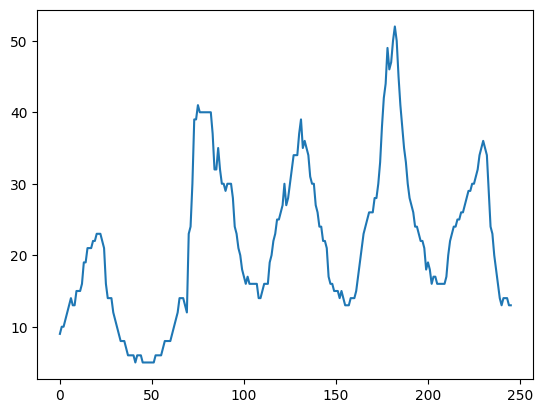

In [30]:
shifted_humidity.plot()

Plotting `apparent_temperature` to ensure that difference is stationary

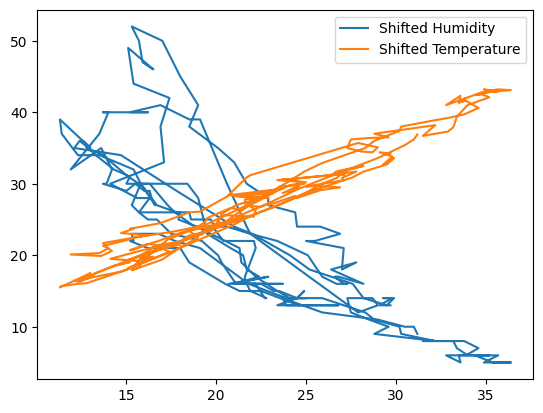

In [11]:
plt.figure()
plt.plot(endog, exog['humidity'], label = 'Shifted Humidity')
plt.plot(endog, exog['temperature'], label = 'Shifted Temperature')
plt.legend()
plt.show()

In [43]:
order = (1, 0, 1) # currently no order difference for apparent temperature
seasonal_order = (1, 0, 1, 48)

model = SARIMAX(endog = endog[:TRAIN_SPLIT], exog= exog[:TRAIN_SPLIT], order = order, seasonal_order = seasonal_order, enforce_stationarity = True)
results = model.fit(disp = False)

with open('sarimax_base_model.pkl', 'wb') as f:
    pickle.dump(results, f)

/home/chloekoee/imc/mockBomex/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Incremental Forecasting and Refitting

In [44]:
with open('sarimax_base_model.pkl', 'rb') as f:
    cached_results = pickle.load(f)

predictions = []
actuals = []
confidence_interval = []

for i in range(TRAIN_SPLIT, n-1): 
    exog_next = exog.iloc[[i]] ## use double bracketing if nested
    forecast = cached_results.get_forecast(steps = 1, exog = exog_next)
    predictions.append(forecast.predicted_mean)
    actuals.append(endog.iloc[i])
    confidence_interval.append(forecast.conf_int(alpha=0.05).iloc[0].to_dict()) # 95% confidence interval
    cached_results = cached_results.append(endog = [endog.iloc[i]], exog = exog_next, refit = False)
    


### Plotting Forecast & Confidence

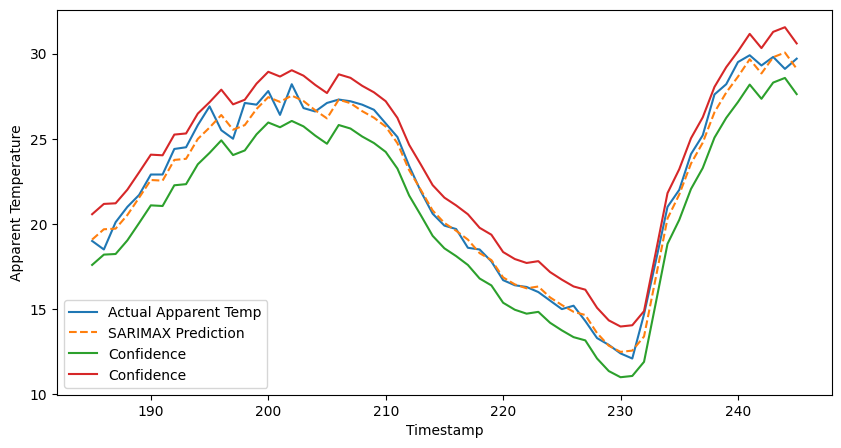

In [28]:
time_index = endog.index[TRAIN_SPLIT:n-1]
confidence = pd.DataFrame(confidence_interval)

plt.figure(figsize=(10, 5))
plt.plot(time_index, actuals, label='Actual Apparent Temp')
plt.plot(time_index, predictions, label='SARIMAX Prediction', linestyle='--')
plt.plot(time_index, confidence, label = 'Confidence')
plt.xlabel('Timestamp')
plt.ylabel('Apparent Temperature')
plt.legend()
plt.show()


### Plot Model 
Setting `dynamic = False` plots the models predictions for each timestamp where $\text{prediction}_t$ uses $\text{observed}_{t-1}$ rather than $\text{prediction}_{t-1}$

If want to evaluate model's prediction for longer time horizons set start and end to capture horizon, and set dynamic = True

The model will gradually get worse as errors compound (from successively using prediction values rather than observation values)

<Axes: >

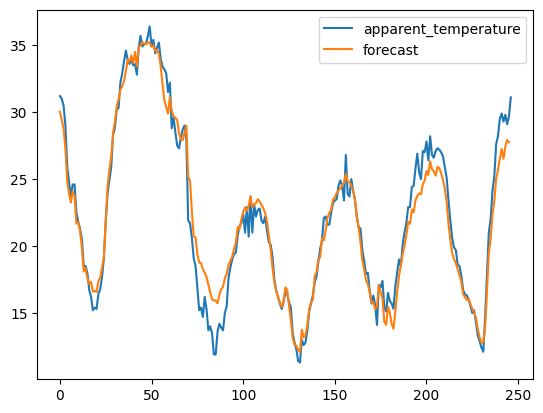

In [31]:
weather['forecast'] = cached_results.predict(start = 0, end = n-2, dynamic = True)
weather[['apparent_temperature', 'forecast']].plot()